In [136]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [129]:
file_name = 'pre_processado_completo.csv'

df = pd.read_csv(file_name, header=0, error_bad_lines=False, warn_bad_lines=False, low_memory=False)

In [130]:
df.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The...,29.883056,-97.941111,1949-10-10
1,lackland afb,tx,NaN,light,120.000000,1949 Lackland AFB&#44 TX. Lights racing across the sky &amp; making 90 degree turns on a dime.,29.384210,-98.581082,1949-10-10
2,chester (uk/england),NaN,gb,circle,0.333333,Green/Orange circular disc over Chester&#44 England,53.200000,-2.916667,1955-10-10
3,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took ...,28.978333,-96.645833,1956-10-10
4,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/attack aircraft on a solo night exercise&#44 I was at 50&#44000&#39 in a ...,21.418056,-157.803611,1960-10-10


In [131]:
# define um array com as latitudes e longitudes

lat_lon = np.array(df[['longitude', 'latitude']]).astype(float)
print(len(lat_lon))
print(lat_lon)

88673
[[-97.9411111  29.8830556]
 [-98.581082   29.38421  ]
 [ -2.916667   53.2      ]
 ...
 [-97.4777778  35.6527778]
 [-82.6958333  34.3769444]
 [-80.1436111  26.1219444]]


### Analise por estados

In [132]:
# define uma lista com os estados, e calcula o peso de cada estado de acordo com a quantidade de avistamentos, pelo método count

states = list(df['state'])
pesos = [states.count(s) for s in states]

In [133]:
scaler = MinMaxScaler()

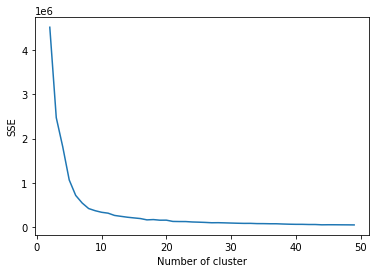

In [134]:
# aplica o elbow criteria

sse = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### De acordo com o Elbow Criteria o número adequado de clusters é em torno de ??

In [ ]:
# aplica o coeficiente de silhouette

for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon))
    label = kmeans.labels_
    sil_coeff = metrics.silhouette_score(scaler.fit_transform(lat_lon), label, metric='euclidean')
    print("Para n_clusters={}, o coeficiente de  Silhouette {}".format(k, sil_coeff))

Para n_clusters=2, o coeficiente de  Silhouette 0.7593161399303028
Para n_clusters=3, o coeficiente de  Silhouette 0.7257981421528658
Para n_clusters=4, o coeficiente de  Silhouette 0.5207548871119816
Para n_clusters=5, o coeficiente de  Silhouette 0.5301768915121043
Para n_clusters=6, o coeficiente de  Silhouette 0.4880129504323445
Para n_clusters=7, o coeficiente de  Silhouette 0.49523711816725746
Para n_clusters=8, o coeficiente de  Silhouette 0.5317585587052521
Para n_clusters=9, o coeficiente de  Silhouette 0.4900831087072283


### De acordo com o Score Silhouette o número adequado de clusters é em torno de ??

In [117]:
# aplica o algoritmo kmeans, utilizando os pesos e normalizando os valores

kmeans = KMeans(n_clusters=25, max_iter=2000)
kmeans.fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
lat_lon_scaled = np.array(scaler.fit_transform(lat_lon))
lat_lon_scaled

array([[0.22167546, 0.72476095],
       [0.21987323, 0.72155423],
       [0.4892746 , 0.87464866],
       ...,
       [0.22298025, 0.7618503 ],
       [0.26460781, 0.7536489 ],
       [0.27179515, 0.70058349]])

In [118]:
centers = kmeans.cluster_centers_
centers

array([[0.26534435, 0.76045273],
       [0.71338144, 0.62471339],
       [0.5248733 , 0.80424891],
       [0.16759859, 0.7504496 ],
       [0.87936554, 0.30935003],
       [0.49778795, 0.53287461],
       [0.26660803, 0.79894012],
       [0.15518199, 0.83586021],
       [0.34982886, 0.37465816],
       [0.22277699, 0.73051337],
       [0.26640303, 0.71033441],
       [0.15502827, 0.77803414],
       [0.28811496, 0.79890076],
       [0.08931037, 0.92842633],
       [0.2034987 , 0.77961583],
       [0.24552412, 0.80166094],
       [0.05319161, 0.64418038],
       [0.85068806, 0.74964423],
       [0.57967871, 0.35088634],
       [0.49828112, 0.87344116],
       [0.7085966 , 0.71711649],
       [0.60880482, 0.75288625],
       [0.93931866, 0.32512255],
       [0.27897858, 0.60236655],
       [0.80819266, 0.57637713]])

In [119]:
locations = kmeans.labels_.astype(float)
print(len(locations))
locations

88673


array([ 9.,  9., 19., ..., 14.,  0., 10.])

Text(0, 0.5, 'Longitude')

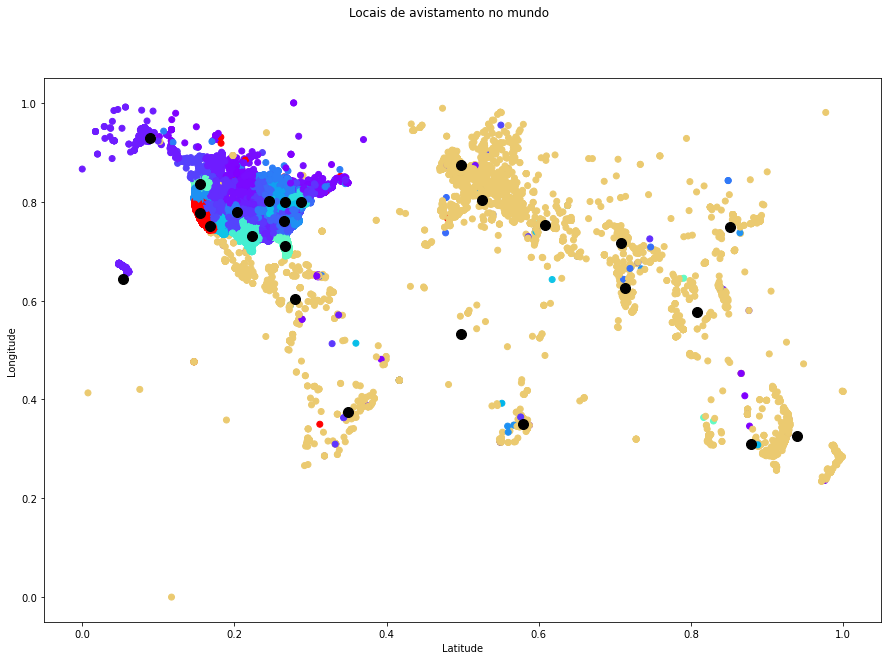

In [120]:
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=pesos, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento no mundo')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [121]:
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [122]:
centers_notscaled = scaler.inverse_transform(centers)
df_centers = pd.DataFrame(centers_notscaled)

for index, row in df_centers.iterrows():
    df_centers.at[index, 'location'] = str(row[1]) + ', ' + str(row[0])

df_centers.drop(0, axis=1, inplace=True)
df_centers.drop(1, axis=1, inplace=True)

df_centers

,location
0,"35.43536677358644, -82.43428825013072"
1,"14.319382127018445, 76.6636610182869"
2,"42.248422467348426, 9.724428429829285"
3,"33.87925243728182, -117.14380452433797"
4,"-34.73940939038447, 135.60460883173343"
5,"0.032688799858211354, 0.1064239871876958"
6,"41.42257208645853, -81.98555610784395"
7,"47.165962220962385, -121.55293957136429"
8,"-24.579897786461945, -52.43384282888304"
9,"30.777917551464814, -97.54995526720849"


In [123]:
df_centers['address'] = df_centers['location'].apply(lambda loc: reverse(loc) if loc else None)

In [124]:
pd.set_option("max_colwidth", 120)
df_centers

,location,address
0,"35.43536677358644, -82.43428825013072","(Terrys Gap Road, Goodluck, Henderson County, North Carolina, 28732, United States, (35.43652302578831, -82.43353096..."
1,"14.319382127018445, 76.6636610182869","(Bharamasagara, Challakere taluku, Chitradurga district, Karnataka, 577522, India, (14.317408633158657, 76.663451703..."
2,"42.248422467348426, 9.724428429829285","(France métropolitaine, France, (46.603354, 1.8883335))"
3,"33.87925243728182, -117.14380452433797","(Riverside County, California, United States, (33.7219991, -116.0372472))"
4,"-34.73940939038447, 135.60460883173343","(Uley, The District Council of Lower Eyre Peninsula, South Australia, 5607, Australia, (-34.72639345, 135.5997845233..."
5,"0.032688799858211354, 0.1064239871876958",None
6,"41.42257208645853, -81.98555610784395","(Red Tail Golf Club, Avon Reserve Path, Avon, Lorain County, Ohio, 44011, United States, (41.42542125, -81.985136745..."
7,"47.165962220962385, -121.55293957136429","(Forest Road 7012, King County, Washington, United States, (47.1642266, -121.557795))"
8,"-24.579897786461945, -52.43384282888304","(Roncador, Região Geográfica Imediata de Campo Mourão, Região Geográfica Intermediária de Maringá, Paraná, Região Su..."
9,"30.777917551464814, -97.54995526720849","(County Road 302, Williamson County, Texas, 76573, United States, (30.782861487697513, -97.55127500377931))"


### Analise por país

In [125]:
# define uma lista com os estados, e calcula o peso de cada estado de acordo com a quantidade de avistamentos, pelo método count

countrys = list(df['country'])
pesos = [countrys.count(c) for c in countrys]

In [126]:
scaler = MinMaxScaler()

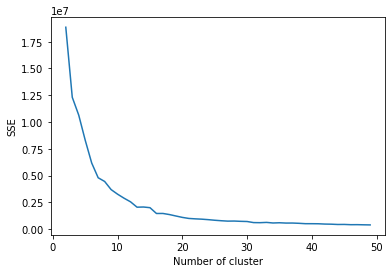

In [127]:
# aplica o elbow criteria

sse = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### De acordo com o Elbow Criteria o número adequado de clusters é em torno de 25

In [101]:
# aplica o algoritmo kmeans, utilizando os pesos e normalizando os valores

kmeans = KMeans(n_clusters=25, max_iter=2000)
kmeans.fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
lat_lon_scaled = np.array(scaler.fit_transform(lat_lon))
lat_lon_scaled

array([[0.22167546, 0.72476095],
       [0.21987323, 0.72155423],
       [0.4892746 , 0.87464866],
       ...,
       [0.22298025, 0.7618503 ],
       [0.26460781, 0.7536489 ],
       [0.27179515, 0.70058349]])

In [102]:
centers = kmeans.cluster_centers_
centers

array([[0.15687578, 0.83277786],
       [0.26293032, 0.7902316 ],
       [0.70157022, 0.69059059],
       [0.50341203, 0.87345601],
       [0.228168  , 0.73193136],
       [0.49813118, 0.53304344],
       [0.94167405, 0.31366204],
       [0.18755572, 0.74918426],
       [0.2653092 , 0.75608593],
       [0.1551672 , 0.77971285],
       [0.07834569, 0.93018323],
       [0.34614657, 0.38983474],
       [0.23498816, 0.77296592],
       [0.26763596, 0.7108684 ],
       [0.55689335, 0.78364404],
       [0.166504  , 0.75228932],
       [0.57905304, 0.35085252],
       [0.25012567, 0.80444384],
       [0.2912105 , 0.80406783],
       [0.84851957, 0.75258301],
       [0.05504159, 0.66625071],
       [0.19577441, 0.7915205 ],
       [0.79464773, 0.58051979],
       [0.28231544, 0.78585563],
       [0.23351954, 0.82413978]])

In [107]:
locations = kmeans.labels_.astype(float)
print(len(locations))
locations

88673


array([ 4.,  4.,  3., ..., 12.,  8., 13.])

Text(0, 0.5, 'Longitude')

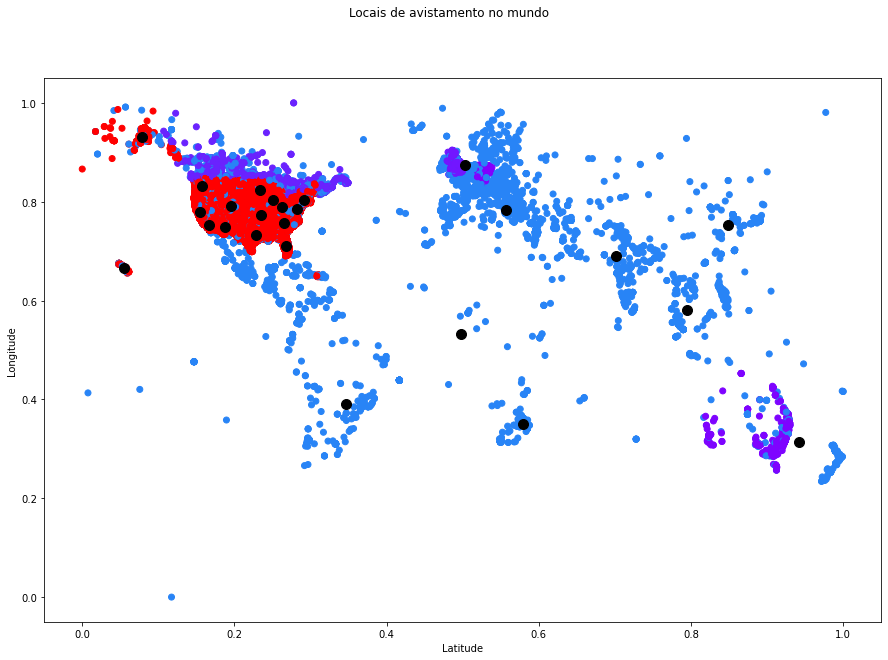

In [108]:
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=pesos, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento no mundo')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [104]:
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [105]:
centers_notscaled = scaler.inverse_transform(centers)
df_centers = pd.DataFrame(centers_notscaled)

for index, row in df_centers.iterrows():
    df_centers.at[index, 'location'] = str(row[1]) + ', ' + str(row[0])

df_centers.drop(0, axis=1, inplace=True)
df_centers.drop(1, axis=1, inplace=True)

df_centers

,location
0,"46.68646404736814, -120.95147254084671"
1,"40.06785003420409, -83.29151191505431"
2,"24.56742010752689, 72.46949715860211"
3,"53.014468107350766, 2.1035327230090557"
4,"30.99850421632221, -95.63561061921094"
5,"0.058953130577402015, 0.22830542257247857"
6,"-34.06862166090674, 157.73035865728994"
7,"33.68241282840122, -110.05702921599334"
8,"34.75605647191592, -82.44677120170616"
9,"38.43152451048449, -121.55818863763112"


In [106]:
df_centers['address'] = df_centers['location'].apply(lambda loc: reverse(loc) if loc else None)

KeyboardInterrupt: 

In [94]:
pd.set_option("max_colwidth", 120)
df_centers

,location,address
0,"30.763858345529027, -97.5309522330298","(Williamson County, Texas, United States, (30.766211, -97.530238))"
1,"0.0717185151855826, 0.27537184164021394",Gana
2,"42.26971484424053, 9.633597971589325","(France métropolitaine, France, (46.603354, 1.8883335))"
3,"43.13486460646272, -75.18350993205074","(Smith Hill Road, Town of Deerfield, Oneida County, New York, 13502, United States, (43.1399808, -75.1837264))"
4,"-24.747628031951933, 147.1833456267617","(Mantuan Downs, Central Highlands Regional, Queensland, Australia, (-24.74868364519122, 147.18152880438024))"
5,"38.17006403316644, -121.60653949506431","(Grand Island Road, Walker Landing, Sacramento County, California, 95641, United States, (38.16509191150955, -121.60..."
6,"47.125403284024145, -121.58182299364749","(National Forest Development Road 7010-310, King County, Washington, United States, (47.122608, -121.584192))"
7,"8.228114204833227, 101.56656710870489","(Gulf of Thailand, (9.87695265, 102.06912149416574))"
8,"27.444055309841946, -81.84673888972178","(Hardee County, Florida, United States, (27.4856349, -81.8196804))"
9,"53.01215848067559, 0.2815468497840502","(Boston Deeps, England, United Kingdom, (53.0091981, 0.2673517))"
